In [190]:
# Import packages
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [191]:
df = pd.read_csv('../data/preprocessed_data.csv') 

In [192]:
label = df['HeartDisease']
data = df.drop('HeartDisease', axis=1) 

In [193]:
# Function to print out metrics for each experiment

def get_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions) 
    print(f"Accuracy: {accuracy} \nF1: {f1} \nPrecision: {precision} \nRecall: {recall}") 

## Base KNN Model with all features

In [194]:
X_train_all, X_test_all, y_train, y_test = train_test_split(data, label, test_size=0.2)

In [195]:
knnmodel_all = KNeighborsClassifier() #using default of 5 for now 
knnmodel_all.fit(X_train_all, y_train)  

KNeighborsClassifier()

In [196]:
y_pred = knnmodel_all.predict(X_test_all)
get_metrics(y_test, y_pred) 

Accuracy: 0.9239130434782609 
F1: 0.9391304347826087 
Precision: 0.9230769230769231 
Recall: 0.9557522123893806


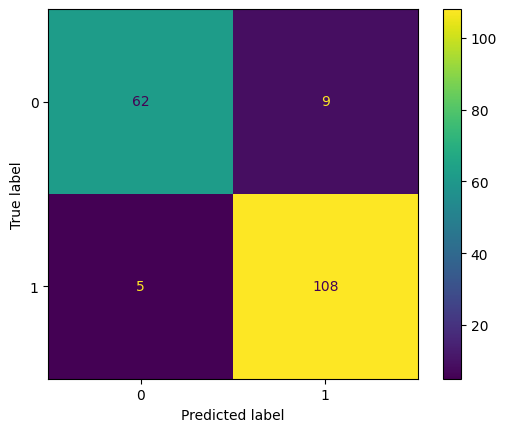

In [197]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot() 

## Grid Search on all features 

In [198]:
param_grid = {'n_neighbors': [2, 3, 5, 10, 15, 20, 50],
              'metric': ['euclidean', 'manhattan', 'minkowski']} # Default is minkowski. 

In [199]:
gridsearch = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid)
gridsearch.fit(X_train_all, y_train) 

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [2, 3, 5, 10, 15, 20, 50]})

In [200]:
gridsearch.best_params_ 

{'metric': 'manhattan', 'n_neighbors': 15}

In [201]:
knnmodel_grid = gridsearch.best_estimator_
y_pred = knnmodel_grid.predict(X_test_all) 

In [202]:
y_pred = knnmodel_grid.predict(X_test_all)
get_metrics(y_test, y_pred) 

Accuracy: 0.9184782608695652 
F1: 0.9344978165938864 
Precision: 0.9224137931034483 
Recall: 0.9469026548672567


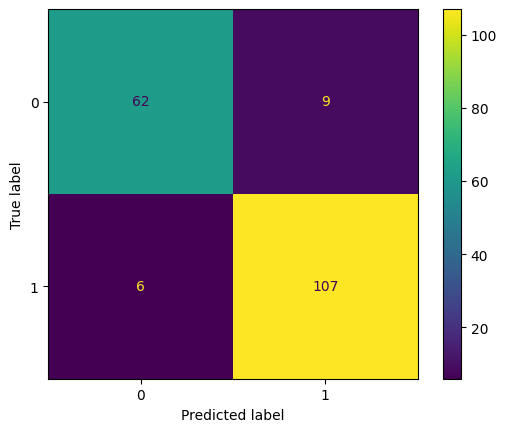

In [203]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

## Using only highly correlated features

In [204]:
#correlation is calculated here to extract features with high correlation
correlation = df.corr()['HeartDisease'].sort_values(ascending=False)

#features with correlation higher than 0.25 with heart disease is done
high_corr_features = correlation[abs(correlation) > 0.25].index.tolist()
high_corr_features.remove('HeartDisease')

In [205]:
# feature matrix for X and Y is selected here
X = df[high_corr_features]
y = df['HeartDisease'] 

In [206]:
X_train_corr, X_test_corr, y_train, y_test = train_test_split(X, y, test_size=0.2)
knnmodel = KNeighborsClassifier() #using default of 5 for now 
knnmodel.fit(X_train_corr, y_train)  

KNeighborsClassifier()

In [207]:
y_pred = knnmodel.predict(X_test_corr) 
get_metrics(y_test, y_pred) 

Accuracy: 0.9021739130434783 
F1: 0.91 
Precision: 0.9191919191919192 
Recall: 0.900990099009901


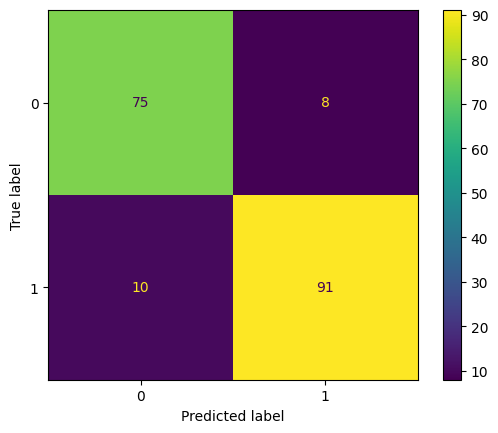

In [208]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

Using highly correlated features results in a better performance.

## Try out PCA

If n_components == 'mle' and svd_solver == 'full', Minka’s MLE is used to guess the dimension. Use of n_components == 'mle' will interpret svd_solver == 'auto' as svd_solver == 'full'.

In [209]:
pca = PCA(n_components='mle') 

In [210]:
X_train_reduced = pca.fit_transform(X_train_all)
X_test_reduced = pca.transform(X_test_all) 

In [211]:
X_train_reduced.shape, X_test_reduced.shape

((734, 15), (184, 15))

In [212]:
knnmodel.fit(X_train_reduced, y_train) 

KNeighborsClassifier()

In [213]:
y_pred = knnmodel.predict(X_test_reduced) 
get_metrics(y_test, y_pred)

Accuracy: 0.45108695652173914 
F1: 0.5429864253393665 
Precision: 0.5 
Recall: 0.594059405940594


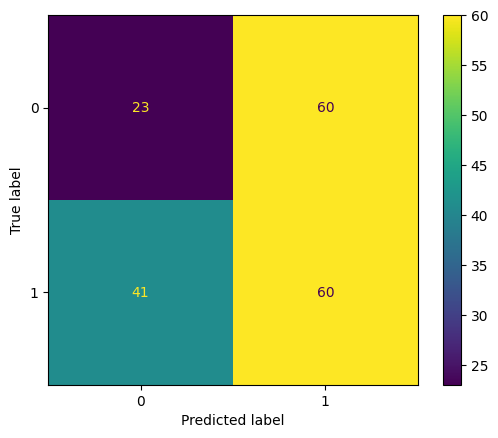

In [214]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

## Backward Feature Selector

In [215]:
from sklearn.feature_selection import SequentialFeatureSelector

In [216]:
knnmodel = KNeighborsClassifier()
sfs = SequentialFeatureSelector(estimator=knnmodel, direction='backward')
sfs.fit(X_train_all, y_train) 

SequentialFeatureSelector(direction='backward',
                          estimator=KNeighborsClassifier())

In [217]:
cols = X_train_all.columns[sfs.support_] 
cols

Index(['scaled_MaxHR', 'scaled_Oldpeak', 'FastingBS_0', 'FastingBS_1', 'Sex_M',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ST_Slope_Flat',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST'],
      dtype='object')

In [218]:
knnmodel.fit(X_train_all[cols], y_train) 

KNeighborsClassifier()

In [219]:
y_pred = knnmodel.predict(X_test_all[cols]) 
get_metrics(y_test, y_pred) 

Accuracy: 0.5054347826086957 
F1: 0.5991189427312775 
Precision: 0.5396825396825397 
Recall: 0.6732673267326733


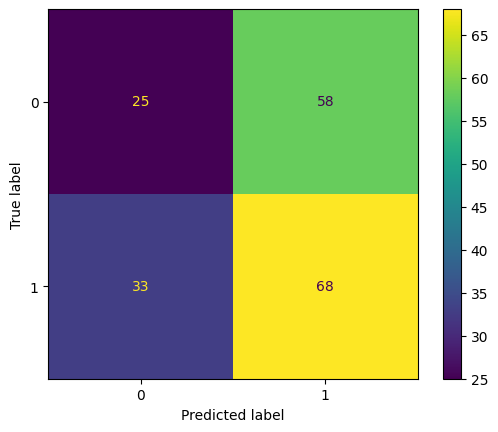

In [220]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot() 